Open a new terminal and run the following commands to install the prerequisites for ns-3

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


Extract the packages to be installed...

In [2]:
packages_file = open('packages.txt', 'r')
packages = packages_file.read().split()

#### Configure the VM

In [3]:
slice_name="hpc-" + fablib.get_bastion_username()

#### Reserve Resources

In [4]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named hpc-nm3833_0000195331 yet.
Continue to the next step to make one.


In [30]:
site_name = fablib.get_random_site()
fablib.show_site(site_name)

Name,FIU
State,Active
Address,"11001 SW 14th St,Miami,FL 33199"
Location,"(0, 0)"
PTP Capable,True
Hosts,5
CPUs,10
Cores Available,408
Cores Capacity,640
Cores Allocated,232
RAM Available,1206


'<pandas.io.formats.style.Styler object at 0x7d3712690a90>'

In [34]:
slice.add_node(name='hpc', site=site_name, 
                   cores=64, 
                   ram=256, 
                   disk=100, 
                   image='default_ubuntu_22')

In [35]:
slice.submit()


Retry: 6, Time: 166 sec


ID,c51c557f-bf4f-4d5b-b8c7-0ec0e17b7a50
Name,hpc-nm3833_0000195331
Lease Expiration (UTC),2024-06-26 18:11:03 +0000
Lease Start (UTC),2024-06-25 18:11:05 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
f13df969-12ad-4291-8f72-810537f0db31,hpc,64,384,1000,default_ubuntu_22,qcow2,fiu-w3.fabric-testbed.net,FIU,ubuntu,131.94.57.41,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.41,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


'c51c557f-bf4f-4d5b-b8c7-0ec0e17b7a50'

In [36]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Configure Resources

In [37]:
slice = fablib.get_slice(name=slice_name)

The following line executes in the background

In [38]:
node = slice.get_node('hpc')
pkg = " ".join(packages)
node.execute_thread("sudo apt update; sudo DEBIAN_FRONTEND=noninteractive apt -y install %s" % pkg)

<Future at 0x7d36f056f750 state=running>

SSH Command for the VM node

In [5]:
import pandas as pd
node = slice.get_node('hpc')
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': node.get_name(), 'SSH command': node.get_ssh_command()}]
print(pd.DataFrame(slice_info).set_index('Name').iloc[0,0])

ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.41


### Extending Slice Expiration

In [5]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta
# Set end date to 3 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

In [6]:
slice.update()
_ = slice.show()

ID,c51c557f-bf4f-4d5b-b8c7-0ec0e17b7a50
Name,hpc-nm3833_0000195331
Lease Expiration (UTC),2024-07-10 19:06:26 +0000
Lease Start (UTC),2024-06-25 18:11:05 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


### Installing NS3

Open the terminal and SSH into Romeo using the SSH command generated during the resource congifuration step.

Run the following commands.
```bash
$  git clone https://gitlab.com/nsnam/bake
$  export BAKE_HOME=`pwd`/bake 
$  export PATH=$PATH:$BAKE_HOME
$  export PYTHONPATH=$PYTHONPATH:$BAKE_HOME
```

```bash
$  bake.py check
$  bake.py configure -e ns-3.42
```

Use the following command to check if there are any missing dependencies and install them manually.
```bash
$  bake.py show
```

Finally
```bash
$  bake.py deploy
```

Configure Environmental Variables
```bash
$  export NS3_HOME=`pwd`
$  export PATH=$PATH:$NS3_HOME
```

Configure and build ns3
```bash
ns3 configure --enable-examples --enable-tests
ns3 build
```

### Simulating TCP congestion control

#### Get simulation code

1. Clone this repo:

```bash
git clone https://github.com/natty6418/TCP-ns3
```

2. Put it in the scratch directory:

```bash
cp -R TCP-ns3/tcp-bbr-replication-experiment source/ns-3.42/scratch/tcp-bbr-repro
```

3. Build the simulation:

```bash
ns3 build
```

#### Run each experiment in sequence

```bash
cd source/ns-3.42/scratch/tcp-bbr-repro/
./simulate-bbr.sh
```



#### Run experiments in parallel


Install SLURM on the resource

```bash
sudo apt update -y
sudo apt install slurmd slurmctld -y
```

```bash
sudo mkdir /etc/slurm-llnl/
sudo chmod 777 /etc/slurm-llnl
sudo mkdir /var/lib/slurm-llnl/
sudo mkdir /var/log/slurm-llnl/
sudo chmod 777 /var/lib/slurm-llnl/
sudo chmod 777 /var/log/slurm-llnl/
```
```bash
sudo ln -s /etc/slurm-llnl/slurm.conf /etc/slurm/slurm.conf
```

In `/etc/slurm/slurm.conf` - 

```bash
# slurm.conf file generated by configurator.html.
# Put this file on all nodes of your cluster.
# See the slurm.conf man page for more information.
#
ClusterName=localcluster
SlurmctldHost=localhost
MpiDefault=none
ProctrackType=proctrack/linuxproc
ReturnToService=2
SlurmctldPidFile=/var/run/slurmctld.pid
SlurmctldPort=6817
SlurmdPidFile=/var/run/slurmd.pid
SlurmdPort=6818
SlurmdSpoolDir=/var/lib/slurm-llnl/slurmd
SlurmUser=slurm
StateSaveLocation=/var/lib/slurm-llnl/slurmctld
SwitchType=switch/none
TaskPlugin=task/none
#
# TIMERS
InactiveLimit=0
KillWait=30
MinJobAge=300
SlurmctldTimeout=120
SlurmdTimeout=300
Waittime=0
# SCHEDULING
SchedulerType=sched/backfill
SelectType=select/cons_tres
SelectTypeParameters=CR_Core
#
#AccountingStoragePort=
AccountingStorageType=accounting_storage/none
JobCompType=jobcomp/none
JobAcctGatherFrequency=30
JobAcctGatherType=jobacct_gather/none
SlurmctldDebug=info
SlurmctldLogFile=/var/log/slurm-llnl/slurmctld.log
SlurmdDebug=info
SlurmdLogFile=/var/log/slurm-llnl/slurmd.log
#
# COMPUTE NODES
NodeName=hpc CPUs=64 Boards=1 SocketsPerBoard=64 CoresPerSocket=1 ThreadsPerCore=1 RealMemory=386748 State=Unknown
PartitionName=LocalQ Nodes=ALL Default=YES MaxTime=INFINITE State=UP

## GRES
GresTypes=gpu,mps
DebugFlags=CPU_Bind,gres
```
Then start with

```bash
sudo service slurmctld restart && sudo service slurmd restart
```

Check with 

```bash
sinfo
```
the `STATE` should be `idle`.

Submit experiments to SLURM

Now you can submit `simulate-bbr-slurm.sh` - 

```bash
sbatch --array=2-115 --ntasks 1 --cpus-per-task 1 simulate-bbr-slurm.sh
```

Use `squeue` to monitor status.

#### Visulaization

Run the following line to download the result data. You should see a success message.

In [7]:
import os
hpc = slice.get_node("hpc")
result = hpc.download_directory(os.getcwd(), "simulation_data")
print(result)

success


In [1]:
!pip install seaborn

In [2]:
import pandas as pd
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import itertools
import os
import re
import matplotlib as mpl


In [3]:
# Assuming 'path_to_results' is the path to the 'tcp-bbr-cubic-results' directory
path_to_results = "simulation_data"
results = []

# List all directories within the results directory
directories = [d for d in os.listdir(path_to_results) if os.path.isdir(os.path.join(path_to_results, d))]

# Parse each directory name to extract the fields
for directory in directories:
    parts = directory.split('_')
    if len(parts) == 4:  # Ensure the directory name contains all expected parts
        qdiscSize = parts[0]  # e.g., 100kB
        bottleneck_bandwidth = parts[1]    # e.g., 250Mbps
        delay = parts[2]      # e.g., 50.0ms
        tcpTypeId = parts[3]  # e.g., TcpBbr

        # print(f"Packet size: {qdiscSize}, bottleneck_bandwidth: {bottleneck_bandwidth}, Latency: {delay}, TCP algorithm: {tcpTypeId}")
        
        goodput_retransmission_path = os.path.join(path_to_results, directory, "goodput_retransmission_results.txt")
        if os.path.exists(goodput_retransmission_path):
            with open(goodput_retransmission_path, 'r') as file:
                goodput_retransmission_data = file.read()
            
            queue_size_path = os.path.join(path_to_results, directory, "queue-size.dat")
            # Regular expression patterns to find throughput and retransmissions
            throughput_pattern = r"Throughput: (\d+\.\d+) Mbps"
            retransmissions_pattern = r"Retransmissions: (\d+)"
            average_delay_pattern = r"Average Delay: (\d+\.\d+)"
            Tx_Packets = r"Tx Packets: (\d+)"
            Rx_Packets = r"Rx Packets: (\d+)"
            # Searching for throughput
            throughput_match = re.search(throughput_pattern, goodput_retransmission_data)
            throughput = throughput_match.group(1)
            # print(f"Throughput: {throughput} Mbps")
            
            # Searching for retransmissions
            Tx_match = re.search(Tx_Packets, goodput_retransmission_data)
            Rx_match = re.search(Rx_Packets, goodput_retransmission_data)
            retransmissions = int(Tx_match.group(1)) - int(Rx_match.group(1))
            # retransmissions_match = re.search(retransmissions_pattern, goodput_retransmission_data)
            # retransmissions = retransmissions_match.group(1)
            # print(f"Retransmissions: {retransmissions}")
            
            # Searching for average delay
            average_delay_match = re.search(average_delay_pattern, goodput_retransmission_data)
            if average_delay_match:
                average_delay = average_delay_match.group(1)
            else:
                average_delay=None
            # print(f"Average Delay: {average_delay} ms")
            
            df = pd.read_csv((queue_size_path), sep='\s+', header=None, names=['Time', 'Value'])
            average = df['Value'].mean()
            # print(f"Average queue-size: {average:.2f}")

            results.append({
                'qdiscSize': qdiscSize,
                'bottleneck_bandwidth': bottleneck_bandwidth,
                'delay': delay,
                'tcpTypeId': tcpTypeId,
                'goodput': throughput,
                'retransmissions': retransmissions,
                'average_queue_size': average,
                'latency':average_delay
            })


In [4]:
df_result = pd.DataFrame(results)
df_result['delay'] = df_result.loc[:,'delay'].str.replace('ms','').astype(float)*4
df_result['delay'] = df_result.loc[:,'delay']
df_result['qdiscSize'] = df_result.loc[:,'qdiscSize'].str.replace('MB','').str.replace('kB','').astype(float)
df_result['bottleneck_bandwidth'] = df_result.loc[:,'bottleneck_bandwidth'].str.replace('Mbps','').astype(float)
df_result = df_result[(df_result['delay'] != 20)]
df_result.head()

,qdiscSize,bottleneck_bandwidth,delay,tcpTypeId,goodput,retransmissions,average_queue_size,latency
0,10.0,20.0,100.0,TcpBbr,18.0998,85,19916.350,0.0595686
1,100.0,50.0,5.0,TcpBbr,45.9917,34,30367.350,0.00802837
2,10.0,250.0,200.0,TcpCubic,226.772,9096,7315559.100,0.345193
3,10.0,50.0,150.0,TcpBbr,45.3898,311,80043.225,0.0887866
4,100.0,50.0,50.0,TcpCubic,45.7623,244,48588.250,0.0335654


In [5]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
# force it to drop bad runs
# df_tput = df_tput.drop(columns=['ret'])
exp_factors = { 
    'qdiscSize': ["100kB", "10MB"],
    'bottleneck_bandwidth': ["10Mbps", "20Mbps", "50Mbps", "100Mbps", "250Mbps", "500Mbps", "750Mbps", "1000Mbps"],
    'delay': [i for i in [200, 10, 25, 50, 75, 100, 150, 5]],
    'tcpTypeId': ["TcpCubic", "TcpBbr"],
    'trial': [1]
}
factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(goodput_gain = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][1]]-df_tput['goodput' + exp_factors['tcpTypeId'][0]])/df_tput['goodput' + exp_factors['tcpTypeId'][0]])

In [6]:
kernel = 'ns3'

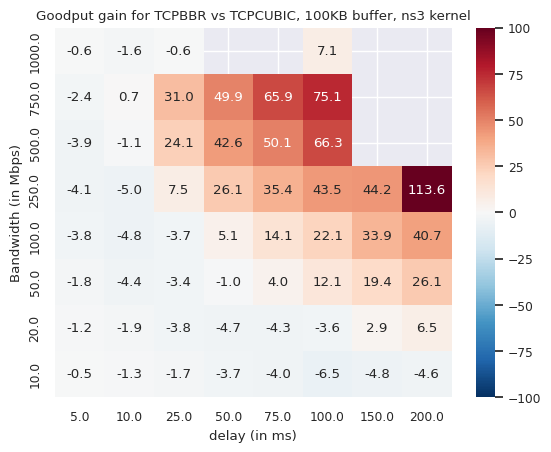

In [7]:
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['tcpTypeId'][1].upper() + " vs " + exp_factors['tcpTypeId'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()
figure = ax.get_figure()
figure.savefig('GG_100k.png')

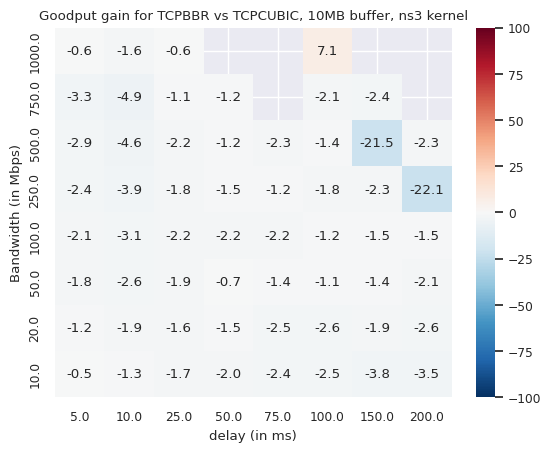

In [8]:
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['tcpTypeId'][1].upper() + " vs " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

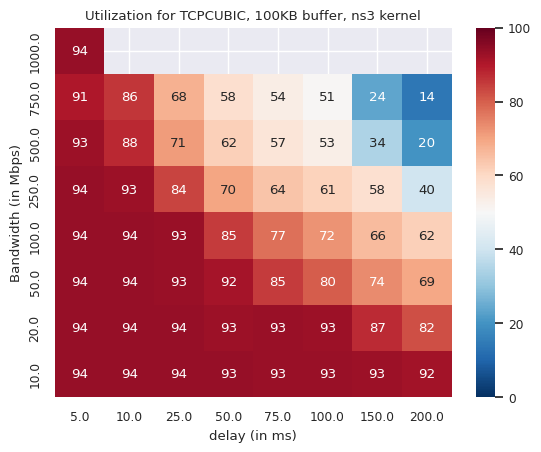

In [9]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput.loc[(df_tput['bottleneck_bandwidth'] == 1000) & (df_tput['delay'] > 5), 'goodput'] = None
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][0] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

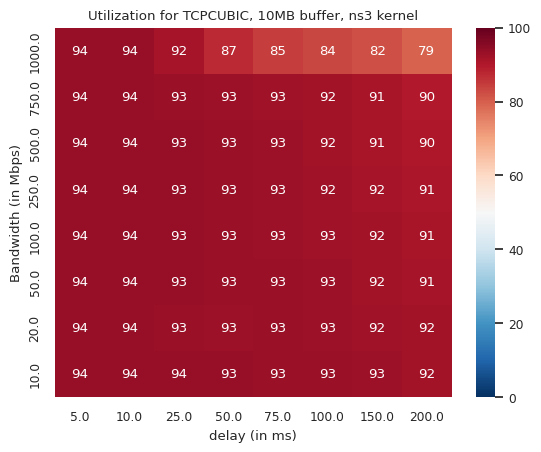

In [10]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][0] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()
figure = ax.get_figure()
figure.savefig('util_10Mb_Bbr.png')

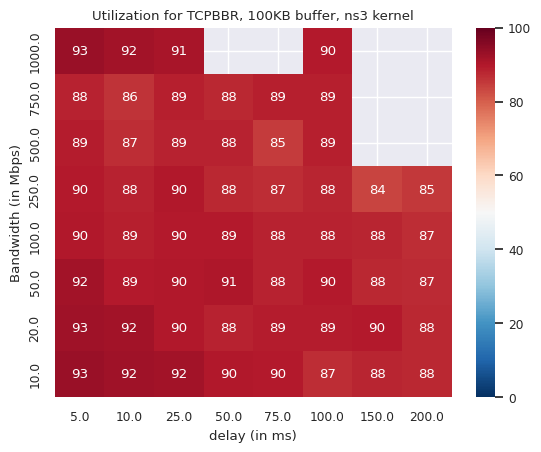

In [11]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][1] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][1].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()
figure = ax.get_figure()
figure.savefig('util_100kB_Bbr.png')

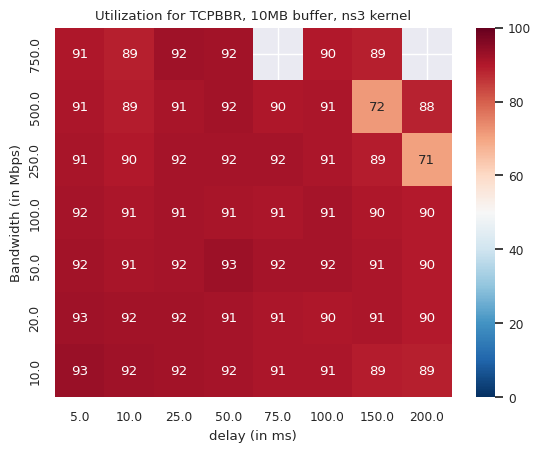

In [18]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][1] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

In [19]:
df_retx = df_result.drop(columns=['average_queue_size','latency','goodput'])
df_retx = df_retx.fillna(0)
df_retx['retransmissions'] = df_retx.loc[:,'retransmissions'].astype(float)/1000
# df_retx.head()
df_retx = df_retx.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['retransmissions'], aggfunc='mean').reset_index() 
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]
df_retx.head()

,qdiscSize,bottleneck_bandwidth,delay,retransmissionsTcpBbr,retransmissionsTcpCubic
0,10.0,10.0,5.0,0.012,9.555
1,10.0,10.0,10.0,0.020,9.583
2,10.0,10.0,25.0,0.035,9.671
3,10.0,10.0,50.0,0.057,8.372
4,10.0,10.0,75.0,0.054,10.051


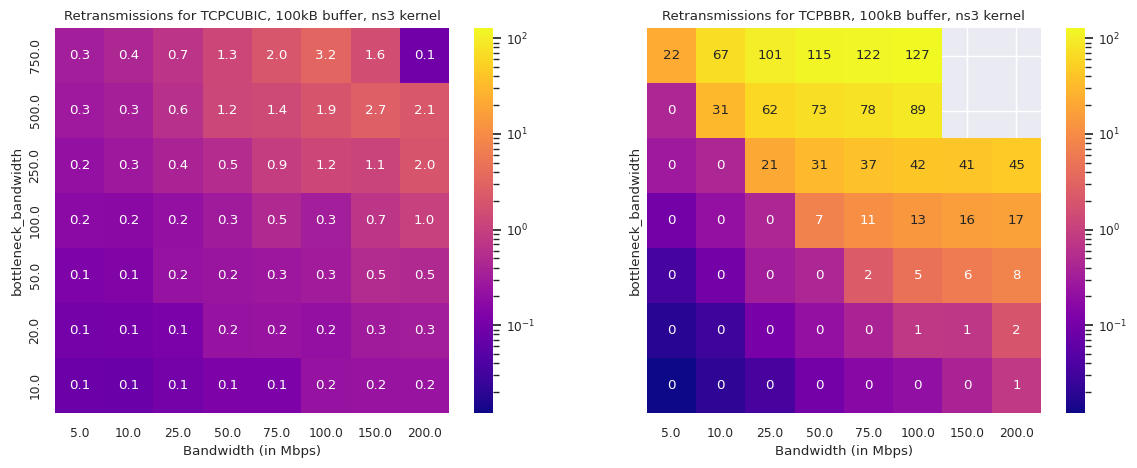

<Figure size 640x480 with 0 Axes>

In [20]:
dat_hm_1 = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][0] )
dat_hm_2 = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][1] )

vmin = min(dat_hm_1.min().min(), dat_hm_2.min().min())
vmax = max(dat_hm_1.max().max(), dat_hm_2.max().max())

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.set(font_scale=0.8)
sns.heatmap(dat_hm_1, ax=axes[0], annot=True, fmt=".1f", norm=LogNorm(vmin=vmin, vmax=vmax), cmap="plasma", cbar=True)
axes[0].invert_yaxis()
axes[0].set_title("Retransmissions for " + exp_factors['tcpTypeId'][0].upper() + ", 100kB buffer, " + kernel + " kernel")
axes[0].set_xlabel("delay (in ms)")
axes[0].set_xlabel("Bandwidth (in Mbps)")

sns.set(font_scale=0.8)
sns.heatmap(dat_hm_2, ax=axes[1], annot=True, fmt=".0f", norm=LogNorm(vmin=vmin, vmax=vmax), cmap="plasma", cbar=True)
axes[1].invert_yaxis()
axes[1].set_title("Retransmissions for " + exp_factors['tcpTypeId'][1].upper() + ", 100kB buffer, " + kernel + " kernel")
axes[1].set_xlabel("delay (in ms)")
axes[1].set_xlabel("Bandwidth (in Mbps)")

plt.show()
plt.tight_layout()
plt.show()
figure = axes[0].get_figure()
figure.savefig('Ret_100kB_Cubic.png')
figure = axes[1].get_figure()
figure.savefig('Ret_100kB_Bbr.png')

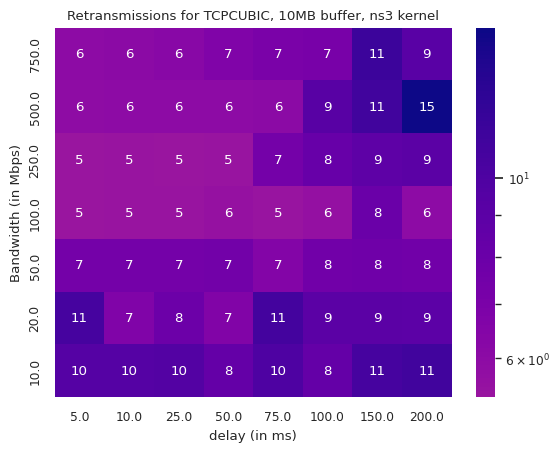

In [21]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="plasma_r",norm=LogNorm(), center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

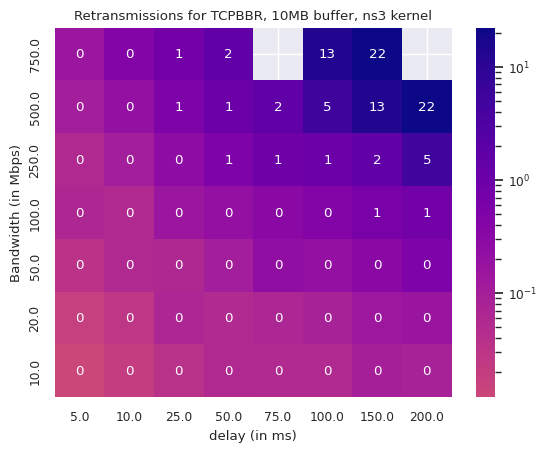

In [22]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="plasma_r", norm=LogNorm(), center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['tcpTypeId'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

In [25]:
df_retx = df_result.drop(columns=['retransmissions','latency','goodput'])
df_retx = df_retx.fillna(0)
df_retx['average_queue_size'] = df_retx.loc[:,'average_queue_size'].astype(float)/1500
# df_retx.head()
df_retx = df_retx.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['average_queue_size'], aggfunc='mean').reset_index() 
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]

# df_retx['buffer_size_per_BDP_TcpCubic'] = df_retx.loc[:,'average_queue_sizeTcpCubic']/(df_retx.loc[:,'average_queue_sizeTcpBbr']*df_retx.loc[:,'average_queue_sizeTcpCubic'])

# df_retx['buffer_size_per_BDP_TcpBbr'] = df_retx.loc[:,'average_queue_sizeTcpBbr']/(df_retx.loc[:,'average_queue_sizeTcpBbr']*df_retx.loc[:,'average_queue_sizeTcpCubic'])
df_retx.head()

,qdiscSize,bottleneck_bandwidth,delay,average_queue_sizeTcpBbr,average_queue_sizeTcpCubic
0,10.0,10.0,5.0,8.049950,3903.147483
1,10.0,10.0,10.0,12.014550,3901.917317
2,10.0,10.0,25.0,20.709267,3902.928450
3,10.0,10.0,50.0,27.354550,3861.668150
4,10.0,10.0,75.0,18.323250,3892.266917


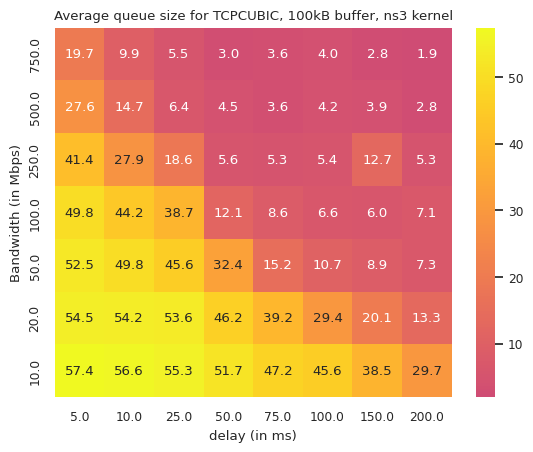

In [26]:
dat_hm = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="average_queue_size"+exp_factors['tcpTypeId'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0001f", cmap="plasma", center=0)
ax.invert_yaxis()
ax.set_title("Average queue size for " + exp_factors['tcpTypeId'][0].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

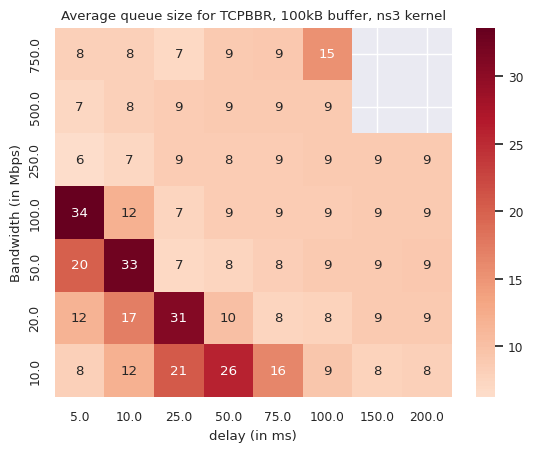

In [27]:
dat_hm = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="average_queue_size"+exp_factors['tcpTypeId'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Average queue size for " + exp_factors['tcpTypeId'][1].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

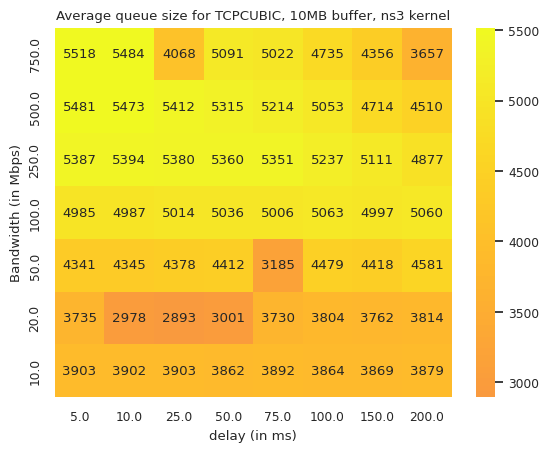

In [119]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="average_queue_size"+exp_factors['tcpTypeId'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="plasma", center=0)
ax.invert_yaxis()
ax.set_title("Average queue size for " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

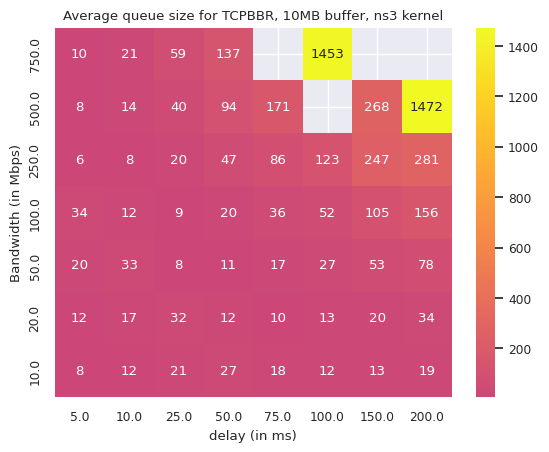

In [120]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="average_queue_size"+exp_factors['tcpTypeId'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="plasma", center=0)
ax.invert_yaxis()
ax.set_title("Average queue size for " + exp_factors['tcpTypeId'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

In [33]:
df_retx = df_result.drop(columns=['retransmissions','average_queue_size','goodput'])
df_retx = df_retx.fillna(0)
df_retx['latency'] = df_retx.loc[:,'latency'].astype(float)*1000
# df_retx.head()
df_retx = df_retx.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['latency'], aggfunc='mean').reset_index() 
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]
df_retx.head()

,qdiscSize,bottleneck_bandwidth,delay,latencyTcpBbr,latencyTcpCubic
0,10.0,10.0,5.0,14.7789,4319.46
1,10.0,10.0,10.0,22.2777,4319.88
2,10.0,10.0,25.0,40.6517,4327.91
3,10.0,10.0,50.0,61.5587,4342.50
4,10.0,10.0,75.0,62.9270,4341.00


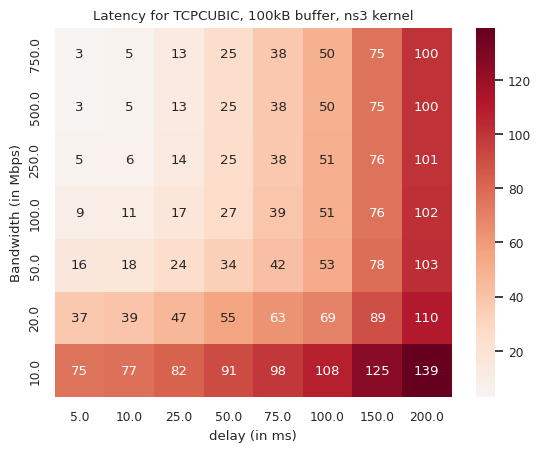

In [34]:
dat_hm = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="latency"+exp_factors['tcpTypeId'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Latency for " + exp_factors['tcpTypeId'][0].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

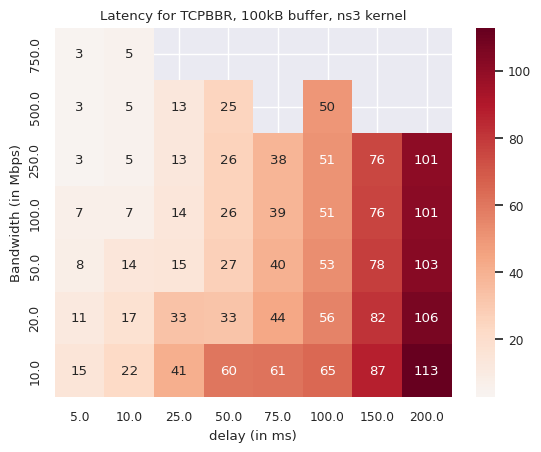

In [41]:
dat_hm = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="latency"+exp_factors['tcpTypeId'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Latency for " + exp_factors['tcpTypeId'][1].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

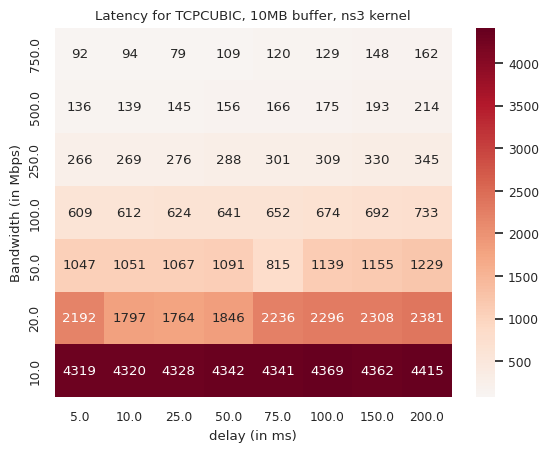

In [42]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="latency"+exp_factors['tcpTypeId'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Latency for " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

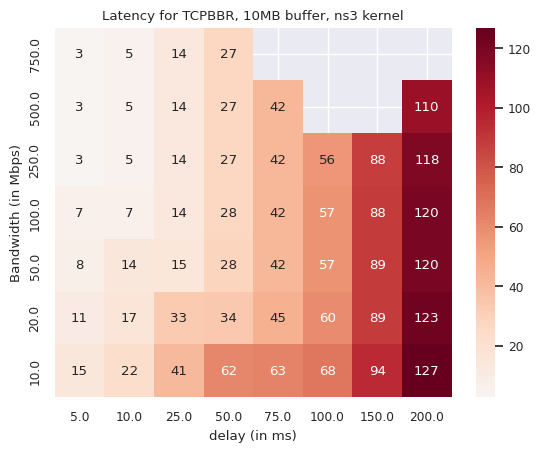

In [43]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="latency"+exp_factors['tcpTypeId'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Latency for " + exp_factors['tcpTypeId'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

<h4 style="color:red;">To delete the slice</h4>

In [22]:
slice = fablib.get_slice(name=slice_name)
fablib.delete_slice(slice_name)

In [23]:
slice.update()
_ = slice.show()

ID,10948f08-483f-45b3-9ebd-de1b60c039bf
Name,tcp_congestion_control_ns3-nm3833_0000195331
Lease Expiration (UTC),2024-06-26 16:40:16 +0000
Lease Start (UTC),2024-06-25 16:40:17 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK
